In [2]:
#libraries for topic modeling
import pandas as pd
import sys
import numpy as np
import csv
import nltk
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.display import display
import matplotlib.pyplot as plt
# uncomment following line to pip install pyLDAvis as needed
#!{sys.executable} -m pip install pyLDAvis
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
import pickle
from lxml import etree as ET
import glob

## Import CSVs
* Import df-sparse-cleaned.csv and df-n.csv from the output of `1_tm_import_clean.ipynb`. 
* Then combine both into a new dataframe to use in this session, 'df_all', matching on n_id and id.

In [3]:
df_R = pd.read_csv('output/background/df-R-cleaned.csv', encoding='utf-8', na_filter=False) #article metadata
df_n = pd.read_csv('output/background/df-n.csv', encoding='utf-8') #article ngrams
df_all = df_R.merge(df_n, left_on='file_name', right_on='n_id')

In [4]:
#total number of records to analyze:
len(df_all)

7773

### Corpus metadata
Run the numbers here on the basic outlines of the corpus; number of articles per year, per journal, etc.

In [7]:
#df_all

In [5]:
%matplotlib inline

In [6]:
#calculate the number of articles by year
year_count = df_R.groupby(['pub_year']).count()[['file_name']]
year_count.columns = ['article_count']
year_count.to_csv('output/background/articles_per_year.csv', encoding='utf-8', index=True, header=True)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


Text(0.5,1,'LQ Corpus: Number of articles per year')

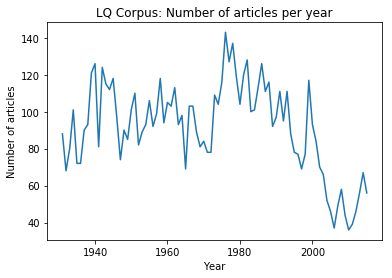

In [7]:
#plot articles by year
x_year = year_count.index
y_count = year_count['article_count']
plt.plot(x_year, y_count)
plt.ylabel("Number of articles")
plt.xlabel("Year")
plt.title('LQ Corpus: Number of articles per year')
#plt.show()
plt.savefig('output/lq_tm/plots/art_per_year.png')

In [10]:
#articles per issue
journals = df_R.groupby(['pub_year', 'volume', 'issue']).count()[['file_name']]
journals.columns = ['article_count']
journals = journals.sort_values('pub_year', ascending=True)
journals
journals.to_csv('output/background/articles_per_issue.csv', encoding='utf-8', index=True, header=True)

article_count
pub_year volume issue               
1931     1      1                 29
                2                 23
                3                 23
                4                 13
1932     2      1                 16
                2                 22
                3                 13
                4                 17
1933     3      4                 20
                3                 21
                1                 21
                2                 18
1934     4      1                 18
                2                 31
                3                 28
                4                 24
1935     5      4                 19
                2                 21
                3                 16
                                   2
                1                 14
1936     6      1                 14
                2                 19
                3                 19
                4                 20
1937     7      4                 23
                3                 24
                1                 19
                2                 24
1938     8      1                 23
...                              ...
2008     78     2                 11
                3                 15
2009     79     3                 13
                4                  9
                1                 13
                2                  9
2010     80     1                 10
                2                 10
                3                  7
                4                  9
2011     81     1                 13
                2                  8
                3                 10
                4                  8
2012     82     4                 12
                3                 12
                2                 11
                1                 11
2013     83     1                 12
                2                 14
                3                 16
                4                 14
2014     84     4                 25
                1                 16
                2                 14
                3                 12
2015     85     2                 15
                3                 13
                1                 13
                4                 15

[342 rows x 1 columns]

In [27]:
# number of entries = number of journal issues
journals.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 342 entries, (1931, 1, 1) to (2015, 85, 4)
Data columns (total 1 columns):
article_count    342 non-null int64
dtypes: int64(1)
memory usage: 5.2+ KB


In [11]:
print('Mean articles per issue:', journals.article_count.mean())

Mean articles per issue: 22.728070175438596


In [30]:
#articles per year
journals = df_R.groupby(['pub_year']).count()[['file_name']]
journals.columns = ['article_count']
journals = journals.sort_values('pub_year', ascending=True)
journals.article_count.mean()
#journals.to_csv('output/background/articles_per_year.csv', encoding='utf-8', index=True, header=True)

91.44705882352942

In [12]:
mean_articles_issue = journals.groupby(['pub_year']).mean()[['article_count']]
#mean_articles_issue.to_csv('output/background/mean_articles_per_issue.csv', encoding='utf-8', index=True, header=True)

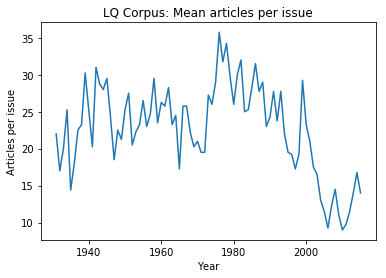

In [14]:
x_year = mean_articles_issue.index
y_count = mean_articles_issue['article_count']
plt.plot(x_year, y_count)
plt.ylabel("Articles per issue")
plt.xlabel("Year")
plt.title('LQ Corpus: Mean articles per issue')
#plt.show()
plt.savefig('output/lq_tm/plots/mean_art_per_issue.png')

In [10]:
#count by type of article
type_count = df_R.groupby(['article_type']).count()[['file_name']]
type_count.columns = ['type_count']
type_count = type_count.sort_values('type_count',ascending=False)
type_count.to_csv('output/background/article_types.csv', encoding='utf-8', index=True, header=True)

In [9]:
#articles per journal title ## Not relevant for LQ study
journals_t = df_R.groupby(['journal_title']).count()[['file_name']]
journals_t.columns = ['journal_count']
journals_t = journals_t.sort_values('journal_count', ascending=False)
journals_t.to_csv('output/background/articles_per_journal_title.csv', encoding='utf-8', index=True, header=True)

In [28]:
#overall wordcount
word_count = df_all['body'].apply(lambda x: len(str(x).split()))
word_count.sum()

16614346

### CountVectorizer & LDA Topic Model
* Convert wordlists from df_all.body to Term Frequency vector. 
* tf = term frequency vector
* lda = latent dirichlet allocation; fit using tf model

In [8]:
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.70, min_df=0.10,
                                max_features=None)

tf = tf_vectorizer.fit_transform(df_all.body.values.astype('U'))

Extracting tf features for LDA...


In [17]:
# list stop words cut off by max_ and min_df thresholds: 
# max_df removes words that appear in more than 70% of articles and min_df removes words that appear in fewer than 10%
# max_df removes 24 words
# min_df removes 145,639  words
with open('output/stop_words_all.txt', 'w') as f:
    for item in tf_vectorizer.stop_words_:
        f.write("%s\n" % item)

### LDA
This cell currently takes ~15 min

In [9]:
n_components = 40 # set the number of topics based on GridSearchCV best model NOTE: n_topics is deprecated

print("Fitting LDA models with tf features, "
      "n_components=%d..."
      % (n_components))

#define the lda function, with desired options
lda = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_components=40...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=40, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:
#to save model
with open('output/lda_model.pk', 'wb') as pickle_file:
    pickle.dump(lda, pickle_file)

In [16]:
#reload lda model from here when restarting notebook
with open('output/lda_model.pk', 'rb') as pickle_file:
    lda = pickle.load(pickle_file)
# then reload it with
#lda = pickle.load('output/lda_model.pk')

In [18]:
print("Log Likelihood: ", lda.score(tf))

Log Likelihood:  -65649964.560244985


In [21]:
print("Perplexity: ", lda.perplexity(tf))

Perplexity:  744.4134338720977


### Top words per topic

In [19]:
#Function to return the top words for each topic
n_top_words = 30 # how many words per topic
topic_word_list = []
def return_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        #topic_n = "\nTopic #%d:" % topic_idx)
        top_words = " ".join([feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]])
        topic_word_list.append(top_words) 
    topic_df = pd.DataFrame(topic_word_list)
    topic_df.to_csv('output/topic_words_lq_only.csv', encoding='utf-8', index=True, header=True)
    return(topic_df)

`topic_word_list[x]` will return the top 30 words for each topic

In [20]:
#print the top words per topic, using the function defined above.
tf_feature_names = tf_vectorizer.get_feature_names()
return_top_words(lda, tf_feature_names, n_top_words)

,0
0,read children reader adult fiction young stori...
1,print press text centuri page edit manuscript ...
2,journal review articl citat cite literatur sci...
3,were had build room year time open place when ...
4,we our what do so can about us like know you m...
5,educ program school faculti profession student...
6,nation countri union state unit intern america...
7,state govern law feder citi local act legal ag...
8,list index includ titl refer volum bibliograph...
9,per cent cost circul total number year tabl ti...


### Most representative articles per topic
`article_list[x]` will return the top 10 articles aligned with each topic

In [22]:
topic_dist = lda.transform(tf)
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(df_all)

In [23]:
article_list = []
d=0
while d < n_components:
    tup = df_w_topics[['article_jcode', 'article_title', 'article_type', 'journal_title', 'jid_combined', 'pub_year', d]].sort_values(by=[d], ascending=False)[0:10]
    article_list.append(tup)
    article_list[d].columns = ['article_jcode', 'article_title', 'article_type', 'journal_title', 'jid_combined', 'pub_year', 'prevalence'] 
    d += 1

In [24]:
#add topic column
for n, i in enumerate(article_list):
    i['topic'] = n
article_lists_df = pd.concat(article_list)

In [21]:
#article_lists_df.info()

In [26]:
#find book review titles in jstor xml since it didn't come through via step 1 (R) and append to top articles list
review_list = []
for index, row in article_lists_df.iterrows():
    if row['article_title'] == '':
        jstor_code = row['article_jcode']
        #insert code to pull book name and author from XML
        review_list.append(jstor_code)
reviews_df_list = []
for n, review in enumerate(review_list):
    xml_files = glob.iglob("metadata/*.xml")
    for xml_file in xml_files: 
        xid = xml_file[:-4].strip('sample-metadata/journal-article-')
        xid = xid.split('_')
        xid = xid[1]
        if xid == review:
            #print('MATCH', review, xml_file)
            tree = ET.parse(xml_file)
            for elem in tree.iter():
                string = elem.text
                if (string is not None) and (string.strip()):
                    path = tree.getelementpath(elem)
                    if path == 'front/article-meta/product/source':
                        reviewed_book = string
                        tup = (xid, reviewed_book)
                        #print(tup)
                        reviews_df_list.append(tup)
        else:
            continue
reviews_df = pd.DataFrame(reviews_df_list, columns=['jid', 'book_reviewed'])    

In [27]:
article_lists_df = article_lists_df.merge(reviews_df, how='outer', left_on='article_jcode', right_on='jid')
article_lists_df = article_lists_df.drop(['jid'], axis=1)
article_lists_df.loc[article_lists_df['article_type']=='book-review', 'article_title'] = article_lists_df['book_reviewed']
article_lists_df = article_lists_df.drop(['book_reviewed'], axis=1)
article_lists_df = article_lists_df.sort_values(by=['topic', 'prevalence'], ascending=[True, False])

In [ ]:
#remove full dupe rows (there was one introducted for the article "Party Girl")
article_lists_df.drop_duplicates(inplace = True) 

In [96]:
article_lists_df.to_csv('output/top_articles_per_topic_lq.csv', encoding='utf-8', index=False, header=True)

In [28]:
#print output to multiple csv files
#OPTIONAL - deprecated by full article_lists_df above
j=0
for i in article_list:
    #display(i)
    filename = 'output/articles_per_topic/top_articles_' + str(j) + '.csv'
    i.to_csv(filename, encoding='utf-8', index=True, header=True)
    j += 1

### Topics over time

In [29]:
df_w_topics['word_count'] = df_w_topics['body'].apply(lambda x: len(str(x).split()))
#df_w_topics['word_count']

In [30]:
#multiple topic weight by word count
topic_columns = range(n_components)
col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['word_count']
#df_w_topics[0:3]

In [31]:
#Find the prevalence of each topic
prevalence = []
i = 0
for e in col_list:
    prev = df_w_topics[e].sum()/df_w_topics['word_count'].sum()
    tup =(i,prev)
    prevalence.append(tup)
    i += 1
prevalence = pd.DataFrame(prevalence)
prevalence.columns = ['topic','prevalence']
prevalence.sort_values(by=['prevalence'], ascending=False)

,topic,prevalence
4,4,0.052164
16,16,0.046975
35,35,0.046289
37,37,0.040688
3,3,0.039892
31,31,0.039479
24,24,0.038220
18,18,0.037981
8,8,0.037809
36,36,0.037052


In [36]:
prevalence.to_csv('output/prevalence_per_topic_lq.csv', encoding='utf-8', index=False, header=True)

In [68]:
grouped_year = df_w_topics.groupby('pub_year')
fig3 = plt.figure()
# divide the number of topic words in each year by the total word count per year (so the figure adjusts to each year's output)
for e in col_list:
    ax2 = fig3.add_subplot(1,1,1)
    (grouped_year[e].sum()/grouped_year['word_count'].sum()).plot(kind='line', title=e)
    fig3.tight_layout()
    #plt.show()
    filename = 'output/plots/plot_' + str(e) + '.png'
    plt.savefig(filename)
    plt.close()

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### Document term matrix
Create document-term-matrix dataframe, dtm_df, to look at the following (ignoring topic models):
* most common words in corpus
* average number of times each word is used in an article

In [38]:
dtm_df = pd.DataFrame(tf_vectorizer.fit_transform(df_all.body.values.astype('U')).toarray(), columns=tf_vectorizer.get_feature_names(), index = df_all.index)

In [39]:
#Find most common words in corpus + avg times each is used in an article 
most_common_words = dtm_df.sum().sort_values(ascending=False)[0:500]
avg_times_used = dtm_df.mean().sort_values(ascending=False)[0:500]
df_top = pd.DataFrame(most_common_words)
df_top.columns = ['word_count']
df_top['avg_used'] = avg_times_used
df_top.to_csv('output/top_words_lq.csv', encoding='utf-8', index=True, header=True)

## Individual articles

In [166]:
topic_10_1 = df_all[df_all['article_jcode'].str.contains('4309398')]
topic_10_1

,file_name,journal_doi,journal_jcode,journal_pub_id,journal_title,article_doi,article_pub_id,article_jcode,article_type,article_title,...,pub_day,pub_month,pub_year,first_page,last_page,page_range,jid_combined,Unnamed: 0,n_id,body
3958,10.2307_4309398,,libraryq,,"The Library Quarterly: Information, Community,...",,,4309398,research-article,"""No Philosophy Carries so Much Conviction as t...",...,1,1,2000,1,46,1-46,libraryq,6291,10.2307_4309398,her her her her her her her her her her her he...


## Alt: Create topic model viz
* Use pyLDA vis to visualize alternate topics generated via scikit-learn
* outputs to html file for future reference outside of notebook
* pyLDAvis is based on LDAvis (for R) and using "relevance" method for ranking terms within a topic

In [98]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.save_html(p,'output/lda_tm_lq.html')

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
